### Проект 2 [Цена дома]

Вам предоставляется набор данных, содержащий информацию о домах и **ценах**. Набор данных уже разделен на ```train.csv``` и ```test.csv```. Файл ```data_description.txt``` содержит описание столбцов.

**Цель:** построить модели для прогнозирования цен на дома.

Пожалуйста, включите подробные объяснения следующих шагов:

1. Очистка, предварительная обработка данных

2. Обучение и проверка моделей.

3. Сравнение моделей на основе метрик регрессии.

**Примечание:** вам **рекомендуется** искать другие алгоритмы машинного обучения в Интернете (не ограничиваясь материалом курса), но вы должны изучить и понять эти алгоритмы. Вы не можете удалить ни одну строку в файле test.csv.

# Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

#Статистика
from scipy.stats import norm, boxcox_normmax
from scipy.special import boxcox1p

#Модель
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

import warnings
warnings.filterwarnings('ignore')

# Просмотр данных

In [2]:
train = pd.read_csv("train.csv")
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1030,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,118000
1,366,70,RM,59.0,10690,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,147000
2,883,60,RL,NaN,9636,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,178000
3,94,190,C (all),60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,133900
4,1360,20,RL,129.0,16737,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Normal,315000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,953,85,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,133900
1310,316,60,RL,71.0,7795,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,188500
1311,206,20,RL,99.0,11851,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,180500
1312,545,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,179665


In [3]:
test = pd.read_csv('test.csv')
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1227,60,RL,86.0,14598,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,214000
1,932,20,RL,70.0,9100,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,7,2009,WD,Normal,117500
2,647,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,98300
3,547,50,RL,70.0,8737,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,210000
4,812,120,RM,NaN,4438,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,ConLD,Normal,144500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
142,1168,60,RL,58.0,10852,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Normal,173000
143,641,120,RL,62.0,12677,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,274000
144,93,30,RL,80.0,13360,Pave,Grvl,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,163500


In [4]:
test_vol = round(test.shape[0] / (train.shape[0] + test.shape[0]), 2) * 100
train_vol = 100 - test_vol
print(f'test: {test_vol}%')
print(f'train: {train_vol}%')

test: 10.0%
train: 90.0%


<b> Данные train и test в соотношении 90% к 10% соответственно. 

In [5]:
# Суммативная статистика для данных train.
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1314.0,731.761796,423.718242,1.0,363.25,731.5,1101.50,1460.0
MSSubClass,1314.0,56.910198,42.469517,20.0,20.00,50.0,70.00,190.0
LotFrontage,1078.0,70.099258,24.695629,21.0,59.00,69.0,80.00,313.0
LotArea,1314.0,10523.983257,10245.456554,1300.0,7558.50,9504.0,11596.00,215245.0
OverallQual,1314.0,6.093607,1.392365,1.0,5.00,6.0,7.00,10.0
OverallCond,1314.0,5.566971,1.120537,1.0,5.00,5.0,6.00,9.0
YearBuilt,1314.0,1971.123288,30.566173,1872.0,1954.00,1972.5,2001.00,2010.0
YearRemodAdd,1314.0,1984.904110,20.698943,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1307.0,102.987758,178.744271,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1314.0,447.671233,459.766632,0.0,0.00,384.0,718.25,5644.0


In [6]:
# Суммативная статистика для целевой переменной (target)
train['SalePrice'].describe()

count      1314.000000
mean     181045.474886
std       79863.285965
min       34900.000000
25%      130000.000000
50%      162950.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

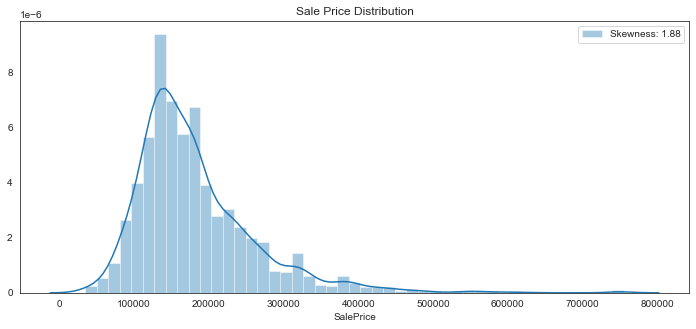

In [7]:
# Распределение цены для данных train
plt.figure(figsize = (12, 5))
sns.set_style('white')
sns.distplot(train['SalePrice'], label = 'Skewness: %.2f'%train['SalePrice'].skew())
plt.legend(loc = 'best')
plt.title('Sale Price Distribution');

In [8]:
# Skewness (ассиметрия кривой) and kurtosis (остроконечность кривой)
print("Skewness: %f"%train['SalePrice'].skew())
print("Kurtosis: %f"%train['SalePrice'].kurt())

Skewness: 1.875845
Kurtosis: 6.443237


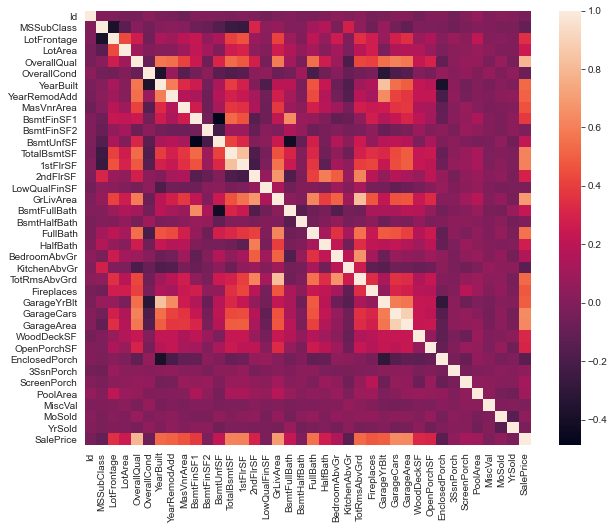

In [9]:
# Корреляция между числовыми данными
corr = train.corr()
fig = plt.figure(figsize=(10,8))
sns.heatmap(corr);

In [10]:
# Наиболее коррелируемые параметры с ценой
corr9 = corr['SalePrice'].sort_values(ascending=False).head(10)
corr9

SalePrice       1.000000
OverallQual     0.792541
GrLivArea       0.697301
GarageCars      0.642377
GarageArea      0.633452
TotalBsmtSF     0.614149
1stFlrSF        0.604703
FullBath        0.555294
YearBuilt       0.529912
TotRmsAbvGrd    0.529226
Name: SalePrice, dtype: float64

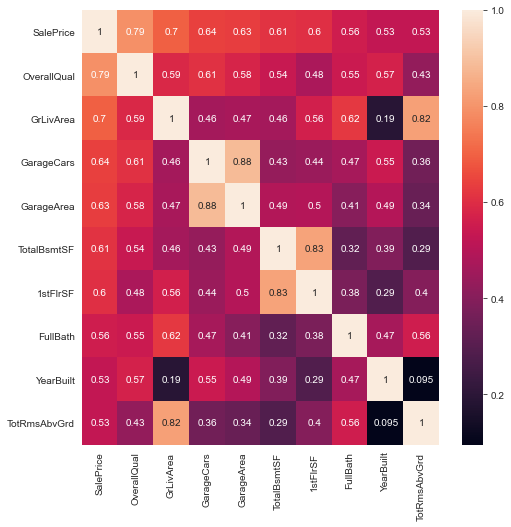

In [11]:
# Корреляция между 9-ю наиболее коррелируемых параметров с ценой
fig = plt.figure(figsize=(8,8))
sns.heatmap(train[corr9.index].corr(), annot=True);

<b>Из приведенных данных для изучения возьмем следующие параметры:

- OverallQual
- GrLivArea
- GarageCars
- TotalBsmtSF
- YearBuilt

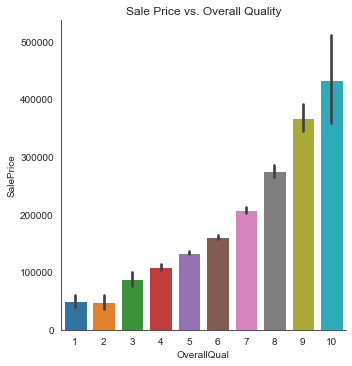

In [12]:
sns.factorplot(x = 'OverallQual', y = 'SalePrice', data = train, kind = 'bar');
plt.title('Sale Price vs. Overall Quality');

<b>Как видно из графика, цена дома растет вместе с повышением качества отделки этого дома.

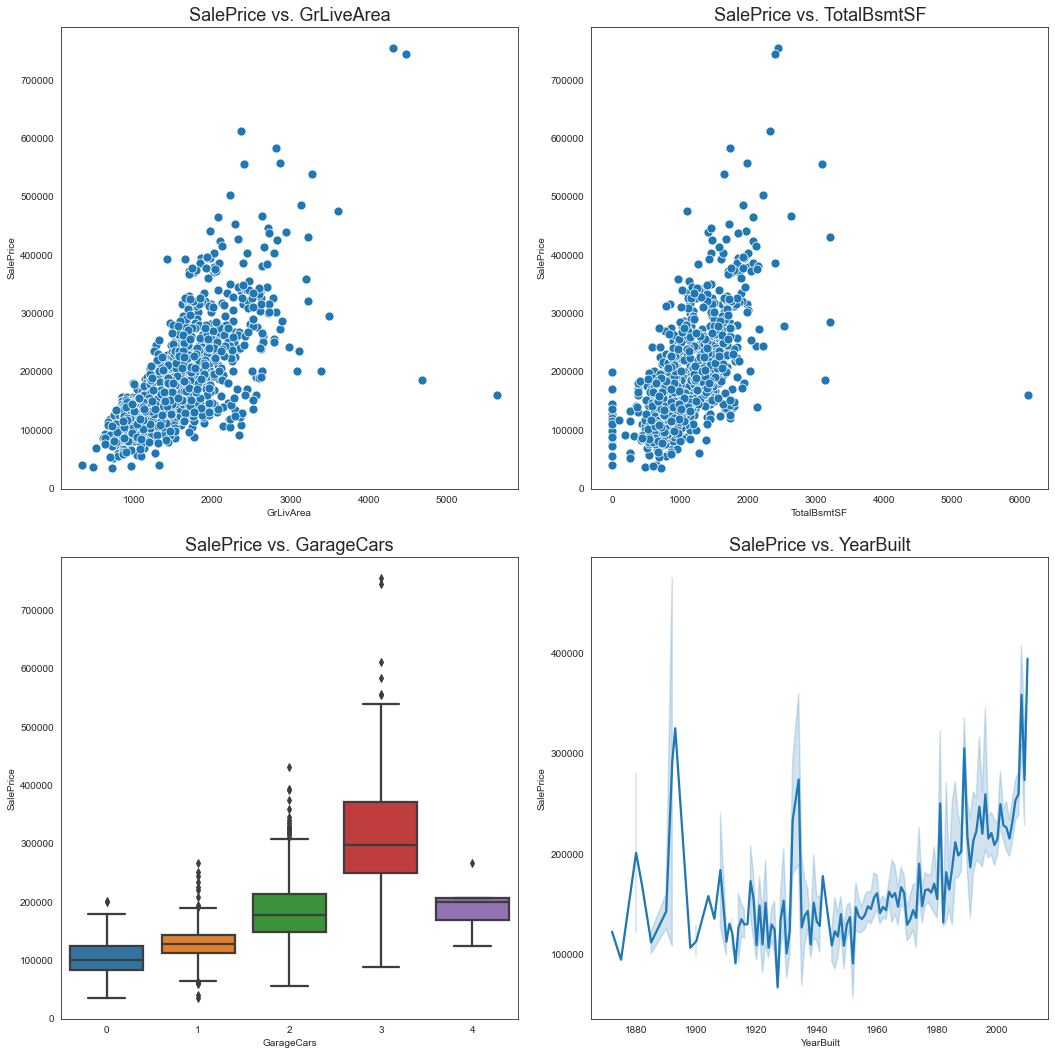

In [13]:
fig , ax = plt.subplots(2,2, figsize=(15,15));

sns.set_style('white')
sns.set_context('talk')

sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, ax=ax[0,0]);
ax[0,0].set_title('SalePrice vs. GrLiveArea');

sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train, ax=ax[0,1]);
ax[0,1].set_title('SalePrice vs. TotalBsmtSF');

sns.boxplot(x='GarageCars', y='SalePrice', data=train, ax=ax[1,0]);
ax[1,0].set_title('SalePrice vs. GarageCars');

sns.lineplot(x='YearBuilt', y='SalePrice', data=train, ax=ax[1,1]);
ax[1,1].set_title('SalePrice vs. YearBuilt');

plt.tight_layout();

<b>Из выше приведенных графиков видно, что в выбранных параметрах есть выбросы(outliers), в параметрах  GrLivArea и TotalBsmtSF справа снизу, которые далее будут удалены. Дома с гаражем для 3-х машин имеют наибольшую цену. Цены на дома в зависимсоти от года постройки в целом имеют тенденцию к росту.  

# Очистка данных

In [14]:
# Параметры с нулевыми значениями
train_isnull = train.isnull().sum()
train_isnull.sort_values(ascending=False).head(25)

PoolQC          1307
MiscFeature     1266
Alley           1231
Fence           1068
FireplaceQu      621
LotFrontage      236
GarageCond        78
GarageType        78
GarageYrBlt       78
GarageFinish      78
GarageQual        78
BsmtExposure      32
BsmtFinType2      32
BsmtFinType1      31
BsmtCond          31
BsmtQual          31
MasVnrArea         7
MasVnrType         7
Electrical         1
Utilities          0
YearRemodAdd       0
MSSubClass         0
Foundation         0
ExterCond          0
ExterQual          0
dtype: int64

In [15]:
test_isnull = test.isnull().sum()
test_isnull.sort_values(ascending=False).head(25)

PoolQC          146
MiscFeature     140
Alley           138
Fence           111
FireplaceQu      69
LotFrontage      23
BsmtFinType1      6
BsmtExposure      6
BsmtCond          6
BsmtQual          6
BsmtFinType2      6
GarageType        3
GarageCond        3
GarageYrBlt       3
GarageFinish      3
GarageQual        3
MasVnrArea        1
MasVnrType        1
Exterior2nd       0
Exterior1st       0
OverallCond       0
ExterQual         0
ExterCond         0
Foundation        0
RoofMatl          0
dtype: int64

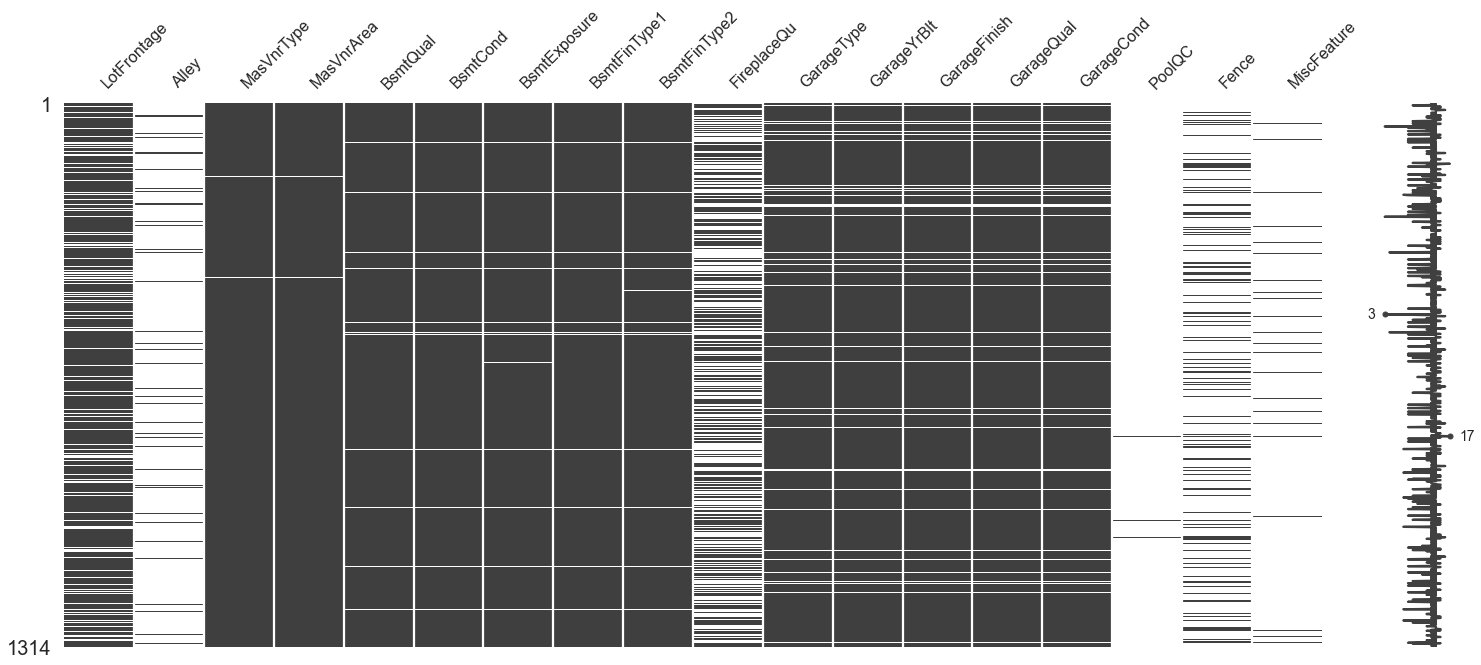

In [16]:
filtered_data = msno.nullity_filter(train, filter='bottom', p=0.999);
msno.matrix(filtered_data);

In [17]:
for i in train.columns:
    null_rate = train[i].isna().sum() / len(train) * 100 
    if null_rate > 0 :
        print(f"{i}'s null rate : {null_rate.round(1)}%")

LotFrontage's null rate : 18.0%
Alley's null rate : 93.7%
MasVnrType's null rate : 0.5%
MasVnrArea's null rate : 0.5%
BsmtQual's null rate : 2.4%
BsmtCond's null rate : 2.4%
BsmtExposure's null rate : 2.4%
BsmtFinType1's null rate : 2.4%
BsmtFinType2's null rate : 2.4%
Electrical's null rate : 0.1%
FireplaceQu's null rate : 47.3%
GarageType's null rate : 5.9%
GarageYrBlt's null rate : 5.9%
GarageFinish's null rate : 5.9%
GarageQual's null rate : 5.9%
GarageCond's null rate : 5.9%
PoolQC's null rate : 99.5%
Fence's null rate : 81.3%
MiscFeature's null rate : 96.3%


<b>Как видно,  больше всего данных отсутствуют в следующих колонках: Alley, PoolQC, MiscFeature и Fence. В каждой из них нет данных больше 80%, поэтому их можно не использовать для построения модели и можно удалить:

In [18]:
train = train.drop(['Alley', 'PoolQC', 'MiscFeature', 'Fence'], axis=1)
test = test.drop(['Alley', 'PoolQC', 'MiscFeature', 'Fence'], axis=1)

<b>Недостающие значения в колонке LotFrontage можно заполнить ее медианой сгруппировав данные по колонке Neighborhood: 

In [19]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

<b>Колонку FireplaceQu можно заполни значением 'NA' - No Fireplace

In [20]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('NA')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NA')

<b>Колонки Bsmt (basement) можно также заполнить значением 'NA' - No Basement:

In [21]:
Bsmt = ['BsmtFinType1', 'BsmtExposure' ,'BsmtCond', 'BsmtQual', 'BsmtFinType2']
train[Bsmt].dtypes

BsmtFinType1    object
BsmtExposure    object
BsmtCond        object
BsmtQual        object
BsmtFinType2    object
dtype: object

In [22]:
train[Bsmt] = train[Bsmt].fillna('NA')
test[Bsmt] = test[Bsmt].fillna('NA')

<b>Те же самые действия проведем для групп колонок Garage и Masonry Veneer

In [23]:
Garage = ['GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual']
train[Garage].dtypes

GarageCond       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
dtype: object

In [24]:
Masonry_Veneer = ['MasVnrArea', 'MasVnrType']
train[Masonry_Veneer].dtypes

MasVnrArea    float64
MasVnrType     object
dtype: object

In [25]:
for feature in Garage:
    if train[feature].dtype == 'object' or test[feature].dtype == 'object':
        train[feature] = train[feature].fillna('NA')
        test[feature] = test[feature].fillna('NA')
    else:
        train[feature] = train[feature].fillna(0)
        test[feature] = test[feature].fillna(0)

In [26]:
for feature in Masonry_Veneer:
    if train[feature].dtype == 'object' or test[feature].dtype == 'object':
        train[feature] = train[feature].fillna('None')
        test[feature] = test[feature].fillna('None')
    else:
        train[feature] = train[feature].fillna(0)
        test[feature] = test[feature].fillna(0)

In [27]:
train_isnull = train.isnull().sum()
train_isnull.sort_values(ascending=False).head(5)

Electrical     1
SalePrice      0
Foundation     0
RoofMatl       0
Exterior1st    0
dtype: int64

In [28]:
test_isnull = test.isnull().sum()
test_isnull.sort_values(ascending=False).head(5)

SalePrice      0
ExterCond      0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

<b>В колонке Electrical в данных train отсутсвует всего одно значение, поэтому его можно удалить:

In [29]:
train = train.dropna()

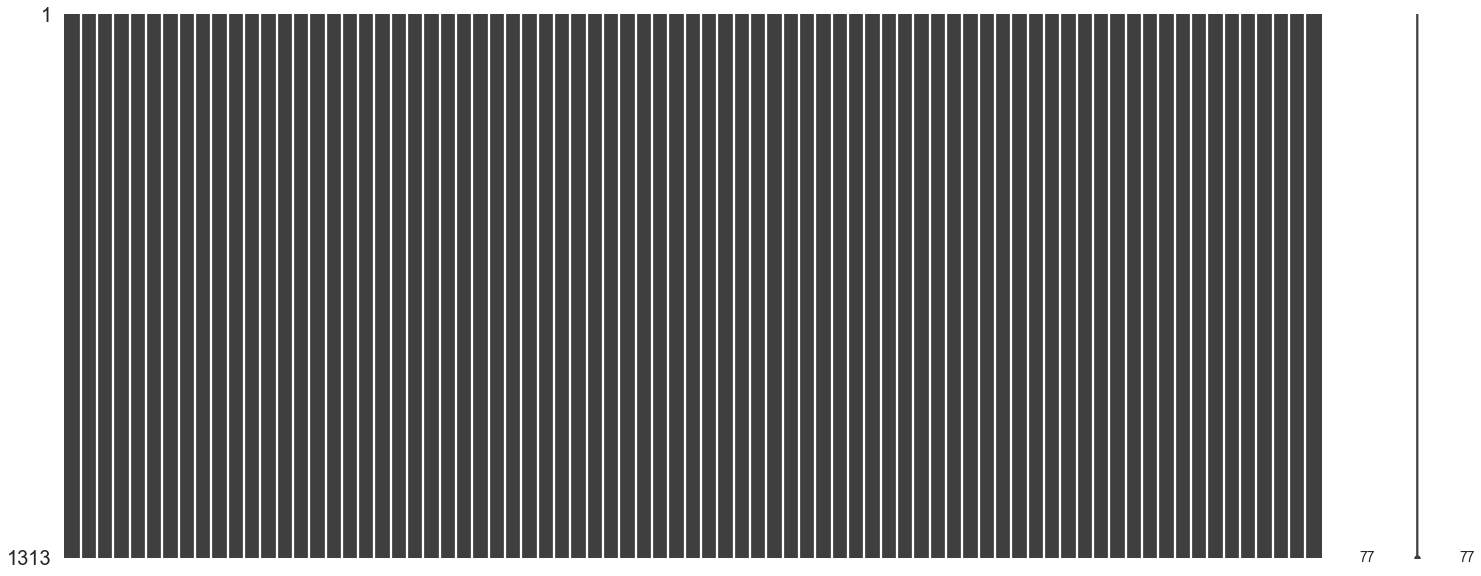

In [30]:
msno.matrix(train);

In [31]:
train.shape

(1313, 77)

<b>Как видно на матрице выше все недостающие данные заполнены. Далее попробуем удалить выбросы для данных train.

In [32]:
# Определим числовые параметры
numerical_features = [feature for feature in train if train[feature].dtype != 'object']

numerical_features.remove('Id')
numerical_features.remove('SalePrice')

print(numerical_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [33]:
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 6, numerical_features)
print(f"Для удаления {len(outliers_to_drop)} выбросов.")

Для удаления 9 выбросов.


In [34]:
train.iloc[outliers_to_drop]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
885,636,190,RH,60.0,10896,Pave,Reg,Bnk,AllPub,Inside,...,0,0,0,0,0,3,2007,WD,Abnorml,200000
403,1174,50,RL,138.0,18030,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,0,0,3,2007,WD,Normal,200500
649,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,0,0,480,0,1,2008,New,Partial,160000
672,524,60,RL,130.0,40094,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,0,0,10,2007,New,Partial,184750
877,1183,60,RL,160.0,15623,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,555,0,7,2007,WD,Abnorml,745000
1050,497,20,RL,92.0,12692,Pave,IR1,Lvl,AllPub,Inside,...,291,0,0,0,0,5,2007,WD,Normal,430000
424,186,75,RM,90.0,22950,Pave,IR2,Lvl,AllPub,Inside,...,0,0,410,0,0,6,2006,WD,Normal,475000
585,692,60,RL,104.0,21535,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,1,2007,WD,Normal,755000
805,1387,60,RL,80.0,16692,Pave,IR1,Lvl,AllPub,Inside,...,0,0,440,519,2000,7,2006,WD,Normal,250000


In [35]:
print(f"До удаления выбросов: {len(train)} строк")
train = train.drop(outliers_to_drop).reset_index(drop = True)
print(f"После удаления выбросов: {len(train)} строк")

До удаления выбросов: 1313 строк
После удаления выбросов: 1304 строк


<b>На примерах колонок GrLivArea и TotalBsmtSF убедимся, что выбросы удалены (можно сравнить с аналогичными графиками выше):

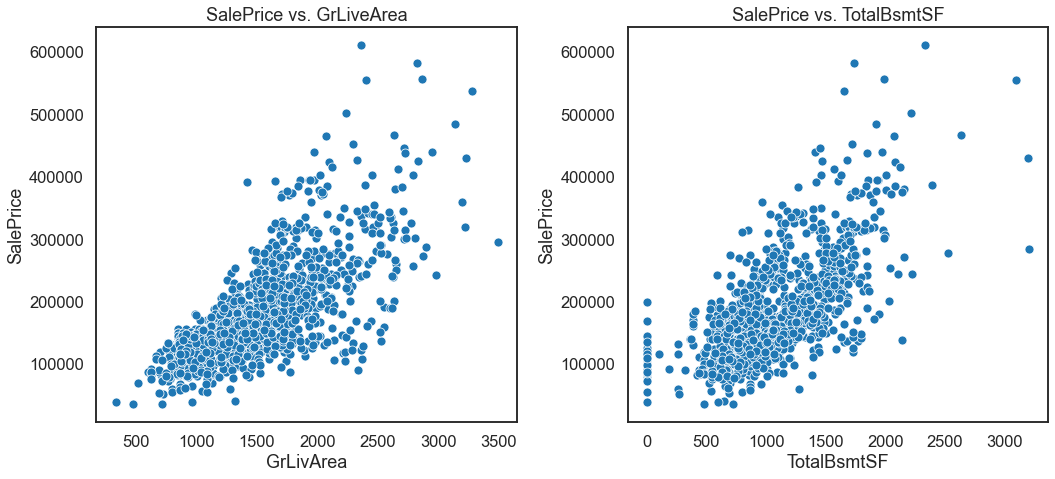

In [36]:
fig , ax = plt.subplots(1,2, figsize=(15,7));

sns.scatterplot(x='GrLivArea', y='SalePrice', data=train, ax=ax[0]);
ax[0].set_title('SalePrice vs. GrLiveArea');

sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train, ax=ax[1]);
ax[1].set_title('SalePrice vs. TotalBsmtSF');

plt.tight_layout()

# Масштабирование и преобразование данных

<b>Проведем логарифмическое преобразование целевой колонки SalePrice (Box-Cox transformation). Данным преобразованием мы нормализуем распределение наших данных, а также вместе с тем нормализуются и ошибки (errors) данных. При этом повышается "сила предиктивности" модели (predictive power of the model), так как данное преобразование помогает устранить так называемые "белые шумы" (white noise). Дискретный белый шум - это последовательность независимых, то есть статистически не связанных друг с другом, чисел.

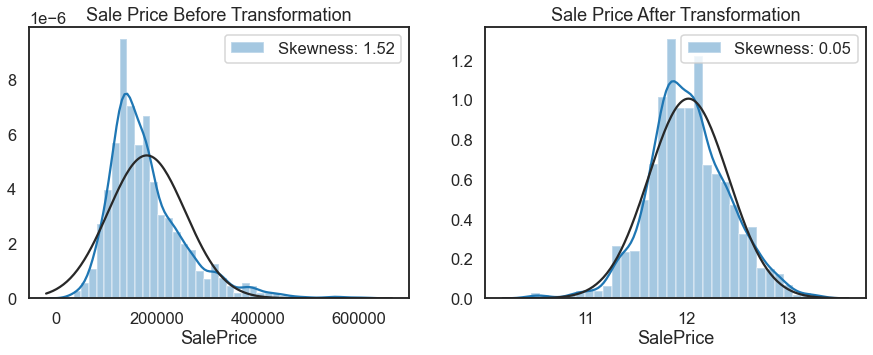

In [37]:
fig, ax = plt.subplots(1, 2)

# До преобразования
sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[0])
ax[0].legend(loc = 'best')
ax[0].title.set_text('Sale Price Before Transformation')

# Box-cox преобразование
train['SalePrice'] = np.log1p(train['SalePrice'])

# После преобразования
sns.distplot(train['SalePrice'], fit = norm, label = 'Skewness: %.2f'%train['SalePrice'].skew(), ax = ax[1])
ax[1].legend(loc = 'best')
ax[1].title.set_text('Sale Price After Transformation')

# Масштабирование осей 
fig.set_figheight(5)
fig.set_figwidth(15)

<b>Коэфициент ассиметрии после преобразования данных колонки SalePrice в данных для train стал равен 0.05. Также применим данное преобразование для числовых колонок для комбинированных данных train и test, где коэфициент ассиметрии выше значения 0.5.

In [38]:
combine = pd.concat([train, test])

In [39]:
skew_features = combine[numerical_features].apply(lambda x: x.skew()).sort_values(ascending = False)
high_skew = skew_features[skew_features > 0.5]
print(f"{len(high_skew)} числовых параметров, у которых коэфициент ассиметрии выше значения 0.5.")
high_skew

25 числовых параметров, у которых коэфициент ассиметрии выше значения 0.5.


MiscVal          24.754159
PoolArea         22.276308
LotArea          12.629987
3SsnPorch        10.268113
LowQualFinSF     10.086374
KitchenAbvGr      4.511043
BsmtFinSF2        4.290283
BsmtHalfBath      4.151714
ScreenPorch       4.029083
EnclosedPorch     2.866229
MasVnrArea        2.652749
OpenPorchSF       2.350695
WoodDeckSF        1.547279
LotFrontage       1.491721
MSSubClass        1.406401
BsmtUnfSF         0.926019
1stFlrSF          0.874527
2ndFlrSF          0.777032
GrLivArea         0.766886
BsmtFinSF1        0.744982
HalfBath          0.687229
OverallCond       0.684295
Fireplaces        0.633501
BsmtFullBath      0.590528
TotRmsAbvGrd      0.574641
dtype: float64

In [40]:
# Box-cox преобразование 25 числовых параметров, у которых коэфициент ассиметрии выше значения 0.5.
for feature in high_skew.index:
    train[feature] = boxcox1p(train[feature], boxcox_normmax(train[feature] + 1))

# Кодировка категорийных данных

In [41]:
print("Before: ", combine.shape)
combine = pd.get_dummies(combine) # Convert categorical variable into dummy/indicator variables.
print("After: ", combine.shape)

Before:  (1450, 77)
After:  (1450, 286)


# Построение модели

<b>Для построения модели сначала определим оптимальный метод построения модели используя cross-validation метод.

In [42]:
# Разделим скомбинированные данные после обработки данных в train и test
train = combine[:len(train)]
test = combine[len(train):]

In [43]:
X_train = train.drop(['Id', 'SalePrice'], axis = 1)
Y_train = train['SalePrice']
X_test = test.drop(['Id', 'SalePrice'], axis = 1)
test_id = test['Id']

In [44]:
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (1304, 284)
Y_train shape:  (1304,)
X_test shape:  (146, 284)


In [45]:
# Cross validation метод
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

In [46]:
# Метрики оценки модели регрессий
def cv_rmse(model, X = X_train, y = Y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = kfolds))
    return rmse

<b>Для моделирования используем следующие регрессоры: 
- Ridge
- Lasso
- Elastic net
- Random forest
- Support vector regressor
- Gradient boosting
- Light GBM
- XGBoost

In [47]:
# Регрессоры
ridge = make_pipeline(RobustScaler(), RidgeCV())
lasso = make_pipeline(RobustScaler(), LassoCV())
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV())
rf = RandomForestRegressor()
svr = SVR()
gbr = GradientBoostingRegressor()
lightgbm = LGBMRegressor()
xgboost = XGBRegressor()

In [48]:
models = [ridge, lasso, elasticnet, rf, svr, gbr, lightgbm, xgboost]
mean = []
std = []
for model in models:
    mean.append(cv_rmse(model).mean())
    std.append(cv_rmse(model).std())

models_df = pd.DataFrame({'Model': ['Ridge', 'Lasso', 'Elastic Net', 'Random Forest', 'SVR', 'Gradient Boosting', 'Light GBM', 'XGBoost'],
                         'Mean': mean, 'Std': std})
models_df.sort_values(by = 'Mean', inplace = True, ignore_index = True)

In [49]:
models_df

,Model,Mean,Std
0,Ridge,0.113284,0.016800
1,Gradient Boosting,0.121637,0.015330
2,Lasso,0.124895,0.016576
3,Light GBM,0.124899,0.015363
4,Elastic Net,0.124903,0.016541
5,XGBoost,0.132761,0.015115
6,Random Forest,0.136815,0.019452
7,SVR,0.203245,0.018678


<b>Как видно, Ridge имеет наименьшую среднеквадратическую ошибку и поэтому будем использовать эту модель для предсказывания тестируемых данных:

In [50]:
ridge_model = ridge.fit(X_train, Y_train)
Y_pred = ridge_model.predict(X_test)
len(Y_pred)

146

In [51]:
ridge_submission = pd.DataFrame({'Id': test_id, 'SalePrice': np.expm1(Y_pred)})
ridge_submission.head()

,Id,SalePrice
0,1227,224104.388864
1,932,124046.608776
2,647,102626.773082
3,547,180273.305526
4,812,165301.717334


# Метрики регрессии

In [52]:
targets = test['SalePrice']
predictions = ridge_submission['SalePrice']

print(f'Mean squared error:{round(metrics.mean_squared_error(targets,predictions),2)}')
print(f'Root mean squared error:{round(metrics.mean_squared_error(targets,predictions, squared=False),2)}')
print(f'Mean absolute error:{round(metrics.mean_absolute_error(targets,predictions),2)}')
r2 = metrics.r2_score(targets,predictions)
n = len(targets)
k = 1
print(f'Coeficient of determination:{round(r2,2)}')
print(f'Adjusted coeficient of determination:{round(1-(((n-1)/(n-k-1))*(1-r2)),2)}')

Mean squared error:312532297.88
Root mean squared error:17678.58
Mean absolute error:12983.89
Coeficient of determination:0.95
Adjusted coeficient of determination:0.94


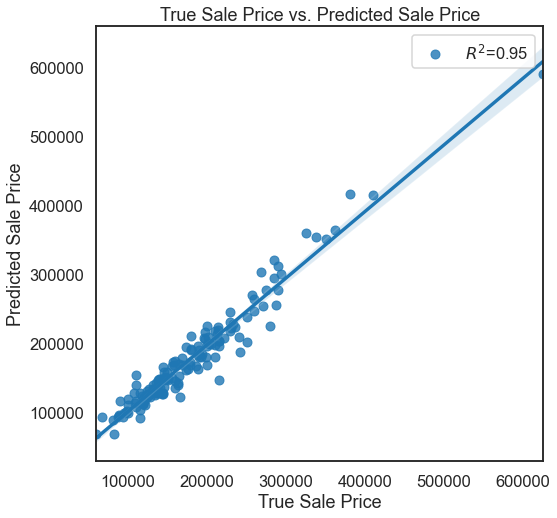

In [53]:
fig = plt.figure(figsize=(8,8))
sns.regplot(targets, predictions, label=f'$R^2$={round(r2,2)}');
plt.title('True Sale Price vs. Predicted Sale Price');
plt.xlabel('True Sale Price');
plt.ylabel('Predicted Sale Price');
plt.legend(loc='best');

<b>Как видно, коэфициент детерминации, который должен в идеальном случае стремиться к единице, равен 0.95.